In [19]:
#@title Imports

import torch
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from einops import rearrange
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.cluster import MiniBatchKMeans


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Define the path to where you saved the dataset

data_root = r"../celeba/"

# Define transforms (resizing, tensor conversion, normalization)
transform = transforms.Compose([
    # transforms.CenterCrop(178),  # Original images are 178x218
    # transforms.Resize(64),       
    transforms.ToTensor(),
    # transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

# Load the dataset
celeba_dataset = datasets.CelebA(
    root=data_root,
    split="train",            # 'train', 'valid', 'test', or 'all'
    target_type="attr",       # 'attr', 'identity', 'bbox', 'landmarks'
    transform=transform,
    download=True            # You've already downloaded it
)

BATCH_SIZE = 64

# Create a DataLoader
dataloader = DataLoader(celeba_dataset, batch_size=BATCH_SIZE, shuffle=True)


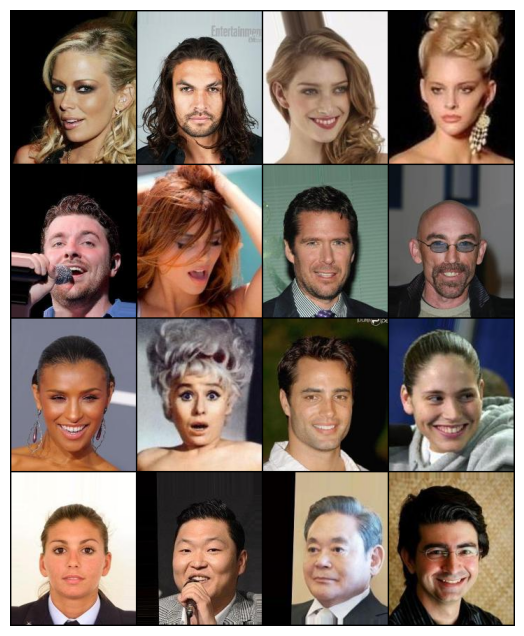

Image size: 218x178, Batch size: 64, Channels: 3


In [22]:
# Show an example batch
images, attributes = next(iter(dataloader))
grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=False)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))  # CHW to HWC
plt.axis('off')
plt.show() 

b,c,h,w = images.shape
IMG_SIZE_H = h
IMG_SIZE_W = w

print(f"Image size: {h}x{w}, Batch size: {b}, Channels: {c}")

# Mini-batch K-means (streaming K-means algorithm for mini-batches)

In [23]:
K = 2 ** 8 # Number of colors
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=BATCH_SIZE)
n_batch = 0
max_n_batch = math.inf
for imgs, _ in tqdm(dataloader):
    # batch: shape [B, D]
    imgs = rearrange(imgs, "b c h w -> (b h w) c")
    kmeans.partial_fit(imgs)
    n_batch += 1
    if n_batch >= max_n_batch:
        break

# Normalize [0, 1] to [0, 255]
palette = torch.tensor(kmeans.cluster_centers_ * 255, dtype=torch.uint8)

100%|██████████| 2544/2544 [35:14<00:00,  1.20it/s]


# Plot the palette

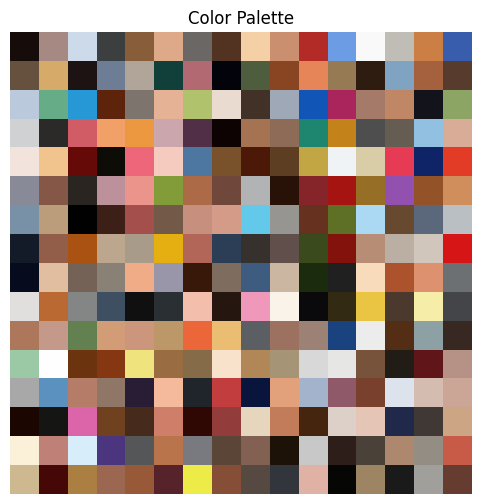

In [24]:
palette.shape# Ensure values are in [0, 1] for matplotlib

copy_palette = palette.clone()

if copy_palette.max() > 1.0:
    copy_palette = copy_palette / 255.0

# Compute size for square grid
num_colors = copy_palette.shape[0]
grid_size = int(math.ceil(math.sqrt(num_colors)))  # e.g., 23x23 for 512

# Pad if not a perfect square
padding = grid_size ** 2 - num_colors
if padding > 0:
    pad = torch.ones(padding, 3)  # white padding or change to zeros for black
    copy_palette = torch.cat([copy_palette, pad], dim=0)

# Reshape to [H, W, 3] for image plotting
palette_image = copy_palette.view(grid_size, grid_size, 3)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(palette_image)
plt.axis('off')
plt.title("Color Palette")
plt.show()

# Save palette

In [25]:
np.save("celeba_palette_8bit.npy", palette.cpu().numpy())

# Load palette

In [26]:
palette = torch.tensor(np.load("celeba_palette_8bit.npy"))

# Sort by brightness

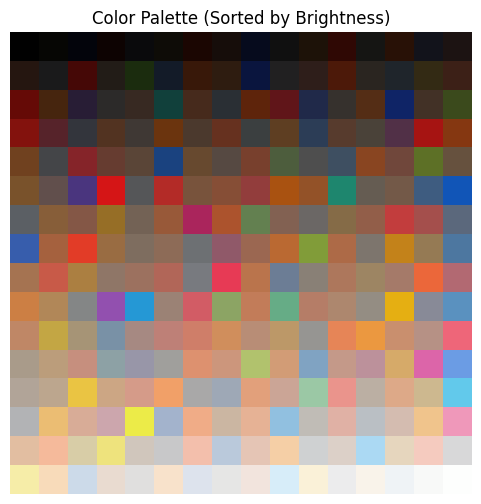

In [27]:
# Clone and normalize
copy_palette = palette.clone()

if copy_palette.max() > 1.0:
    copy_palette = copy_palette / 255.0

# ---- Sort by brightness (sum of RGB values) ----
brightness = copy_palette.sum(dim=1)  # Sum across RGB channels → [512]
sorted_indices = torch.argsort(brightness)
copy_palette = copy_palette[sorted_indices]

# ---- Compute size for square grid ----
num_colors = copy_palette.shape[0]
grid_size = int(math.ceil(math.sqrt(num_colors)))  # e.g., 23x23 for 512

# Pad if not a perfect square
padding = grid_size ** 2 - num_colors
if padding > 0:
    pad = torch.ones(padding, 3)  # white padding
    copy_palette = torch.cat([copy_palette, pad], dim=0)

# ---- Reshape to [H, W, 3] for image plotting ----
palette_image = copy_palette.view(grid_size, grid_size, 3)

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.imshow(palette_image)
plt.axis('off')
plt.title("Color Palette (Sorted by Brightness)")
plt.show()

# Sort by channel

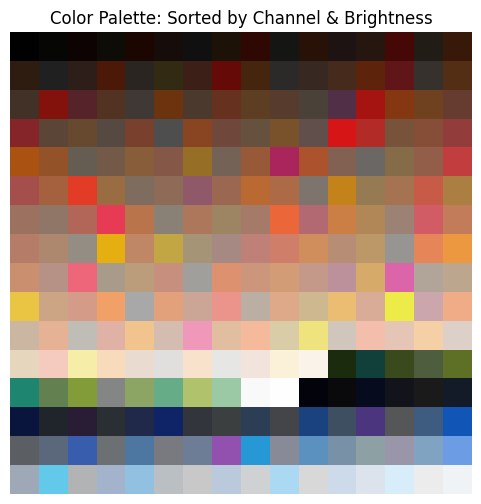

In [28]:
# Clone and normalize
copy_palette = palette.clone()

if copy_palette.max() > 1.0:
    copy_palette = copy_palette / 255.0

# ---- Split into Red, Green, Blue dominant ----
r, g, b = copy_palette[:, 0], copy_palette[:, 1], copy_palette[:, 2]
dominant_channel = torch.argmax(copy_palette, dim=1)

# Get indices for red, green, blue dominant colors
red_idx = (dominant_channel == 0).nonzero(as_tuple=True)[0]
green_idx = (dominant_channel == 1).nonzero(as_tuple=True)[0]
blue_idx = (dominant_channel == 2).nonzero(as_tuple=True)[0]

# Sort each group by brightness (sum of RGB)
def sort_by_brightness(indices):
    colors = copy_palette[indices]
    brightness = colors.sum(dim=1)
    sorted_idx = torch.argsort(brightness)
    return colors[sorted_idx]

sorted_reds = sort_by_brightness(red_idx)
sorted_greens = sort_by_brightness(green_idx)
sorted_blues = sort_by_brightness(blue_idx)

# Concatenate the sorted groups
sorted_palette = torch.cat([sorted_reds, sorted_greens, sorted_blues], dim=0)

# ---- Compute grid size ----
num_colors = sorted_palette.shape[0]
grid_size = int(math.ceil(math.sqrt(num_colors)))

# Pad if not a perfect square
padding = grid_size ** 2 - num_colors
if padding > 0:
    pad = torch.ones(padding, 3)  # white padding
    sorted_palette = torch.cat([sorted_palette, pad], dim=0)

# ---- Reshape and Plot ----
palette_image = sorted_palette.view(grid_size, grid_size, 3)

plt.figure(figsize=(6, 6))
plt.imshow(palette_image)
plt.axis('off')
plt.title("Color Palette: Sorted by Channel & Brightness")
plt.show()

# Quantize image

In [29]:
def quantize_batch_to_palette(images: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Convert a batch of RGB images to use only colors from the given palette.

    Args:
        images: Tensor of shape [B, C, H, W], values in [0, 255]
        palette: Tensor of shape [K, 3], values in [0, 255]

    Returns:
        Tensor of shape [B, C, H, W], quantized images using colors from palette.
    """
    B, C, H, W = images.shape
    assert C == 3, "Expected 3 channels (RGB)"

    # Reshape to [B*H*W, 3]
    pixels = images.permute(0, 2, 3, 1).reshape(-1, 3).float()
    palette = palette.float()

    # Compute distances
    dists = torch.cdist(pixels, palette)  # [B*H*W, K]
    nearest_idx = torch.argmin(dists, dim=1)
    quantized_pixels = palette[nearest_idx]  # [B*H*W, 3]

    # Reshape back to [B, C, H, W]
    quantized = quantized_pixels.reshape(B, H, W, 3).permute(0, 3, 1, 2)
    return quantized.to(torch.uint8)


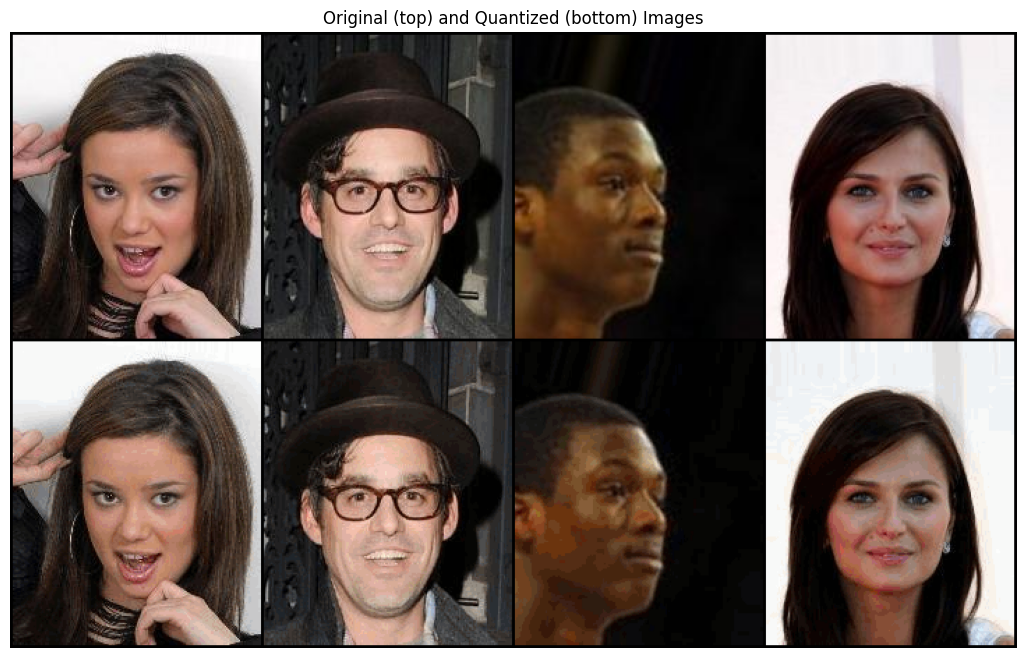

In [30]:
imgs, _ = next(iter(dataloader))

# Use 4 images from batch and scale to 0–255
imgs = (imgs[:4] * 255).to(torch.uint8)

# Quantize the images using your palette
quants = quantize_batch_to_palette(imgs, palette)

# Stack original and quantized images vertically (along batch dimension)
stacked = torch.cat([imgs, quants], dim=0)  # shape: [8, C, H, W]

# Create grid: 4 images per row, so 2 rows
grid = torchvision.utils.make_grid(stacked, nrow=4)

# Rearrange for plotting
grid = rearrange(grid, "c h w -> h w c")

# Plot
plt.figure(figsize=(16, 8))
plt.imshow(grid)
plt.axis("off")
plt.title("Original (top) and Quantized (bottom) Images")
plt.show()
